# Interface with ASE & pymatgen

Supported versions of ASE/pymatgen can be installed from the `requirements/optional-requirements.txt` file, or via `pip install matador-db[optional]`. This allows for `matador.crystal.Crystal` objects to be converted to `ase.Atoms` and `pymatgen.Structure` objects, as shall be showcased below.

First, let's use the builder functionality from ASE to create a crystal structure (example from the `ase.build` [docs](https://wiki.fysik.dtu.dk/ase/ase/build/build.html)).

In [1]:
import ase.build
gnr1 = ase.build.graphene_nanoribbon(
    3, 4, type='armchair', saturated=True, vacuum=3.5
)
print(gnr1)

Atoms(symbols='C48H16', pbc=[False, False, True], cell=[15.03671574711959, 7.0, 17.04])


Let's attach some metadata using the `Atoms.info` property:

In [2]:
gnr1.info = {
    "source": "ase.build.graphene_nanoribbon",
    "chiral_vector": (3, 4),
    "saturated": True,
    "vacuum": 3.5
}

We can now convert this to a matador-style dictionary, or a `matador.crystal.Crystal` object:

In [3]:
from matador.utils.ase_utils import ase2dict
from matador.crystal import Crystal
gnr1_doc = ase2dict(gnr1)
print(gnr1_doc.keys())
print('----')
gnr1_crystal = ase2dict(gnr1, as_model=True)
print(gnr1_crystal)

dict_keys(['atom_types', 'positions_frac', 'lattice_cart', 'lattice_abc', 'num_atoms', 'stoichiometry', 'cell_volume', 'elems', 'num_fu', 'space_group', 'ase_info'])
----
C₃H: unknown
64  atoms. Pmma
(a, b, c) = 15.0367 Å, 7.0000 Å, 17.0400 Å
(α, β, γ) = 90.0000° 90.0000° 90.0000°



In the Crystal print out, the "unknown" means that matador could not find any metadata regarding the source of the structure, so let's use the ASE metadata to update that.

In [4]:
# all underlying data will be copied to the `_data` attribute of the Crystal, 
# if we want, these keys can be promoted to the actual Crystal data itself
gnr1_crystal.update(gnr1_crystal._data["ase_info"])
print(gnr1_crystal)

C₃H: ase.build.graphene_nanoribbon
64  atoms. Pmma
(a, b, c) = 15.0367 Å, 7.0000 Å, 17.0400 Å
(α, β, γ) = 90.0000° 90.0000° 90.0000°



We can now use matador functionality on this graphene nanoribbon:

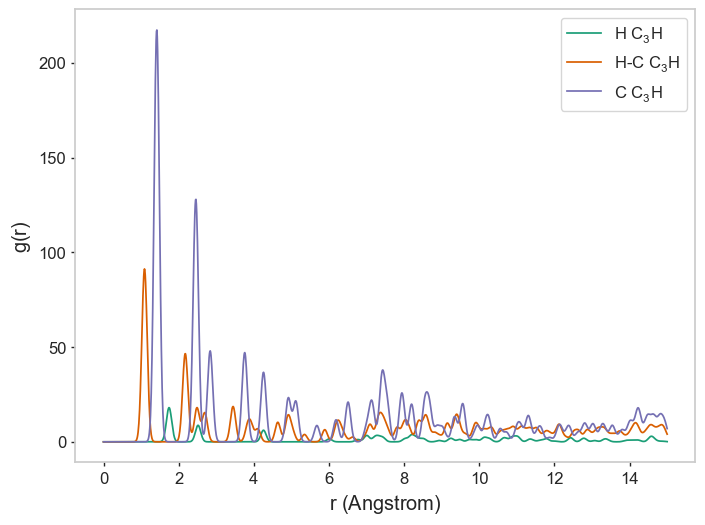

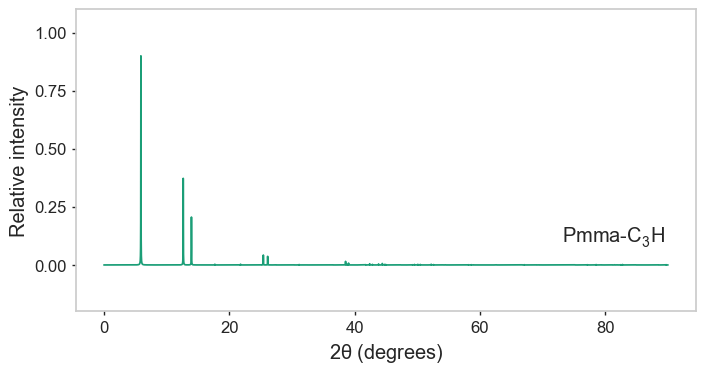

In [5]:
gnr1_crystal.pdf.plot_projected_pdf()
gnr1_crystal.pxrd.plot()

Calculated: 110592, Used: 1616, Ignored: 108976
Calculated distances in 0.001687765121459961 s
{'species': 'C', 'position': array([0.62267533, 0.5       , 0.        ]), 'bonds': [{'species': 'C', 'index': 1, 'length': 1.4199999999999997, 'is_image': False, 'position': array([0.70445889, 0.5       , 0.04166667])}, {'species': 'C', 'index': 15, 'length': 1.42, 'is_image': True, 'position': array([0.62267533, 0.5       , 0.91666667])}, {'species': 'C', 'index': 17, 'length': 1.4199999999999997, 'is_image': False, 'position': array([0.54089178, 0.5       , 0.04166667])}]}


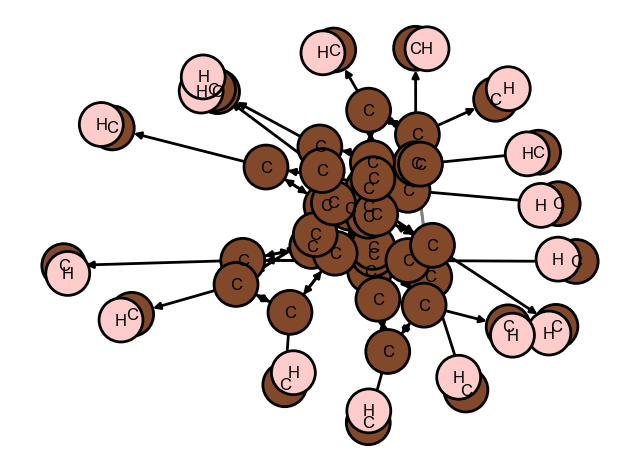

In [6]:
from matador.crystal.network import draw_network
draw_network(gnr1_crystal.network)
print(gnr1_crystal.bonding_stats[0])

We can now convert this Crystal object freely between ASE and pymatgen. Let's make a pmg structure from the Crystal, modify it, then make a new Crystal:

In [7]:
pmg_structure = gnr1_crystal.pmg_structure
for ind, site in enumerate(pmg_structure):
    if ind % 2 == 0:
        pmg_structure[ind] = "N"
print(pmg_structure)

Full Formula (H8 C24 N32)
Reduced Formula: HC3N4
abc   :  15.036716   7.000000  17.040000
angles:  90.000000  90.000000  90.000000
Sites (64)
  #  SP           a    b         c
---  ----  --------  ---  --------
  0  N     0.622675  0.5  0
  1  C     0.704459  0.5  0.041667
  2  N     0.704459  0.5  0.125
  3  C     0.622675  0.5  0.166667
  4  N     0.622675  0.5  0.25
  5  C     0.704459  0.5  0.291667
  6  N     0.704459  0.5  0.375
  7  C     0.622675  0.5  0.416667
  8  N     0.622675  0.5  0.5
  9  C     0.704459  0.5  0.541667
 10  N     0.704459  0.5  0.625
 11  C     0.622675  0.5  0.666667
 12  N     0.622675  0.5  0.75
 13  C     0.704459  0.5  0.791667
 14  N     0.704459  0.5  0.875
 15  C     0.622675  0.5  0.916667
 16  N     0.459108  0.5  0
 17  C     0.540892  0.5  0.041667
 18  N     0.540892  0.5  0.125
 19  C     0.459108  0.5  0.166667
 20  N     0.459108  0.5  0.25
 21  C     0.540892  0.5  0.291667
 22  N     0.540892  0.5  0.375
 23  C     0.459108  0.5  0.4166

/home/mevans/.local/conda/envs/matador_thesis/lib/python3.8/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/mevans/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")


In [8]:
gnr1_doped_crystal = Crystal.from_pmg(pmg_structure)

Now we can plot the C-N, N-N and H-N pair distribution functions:

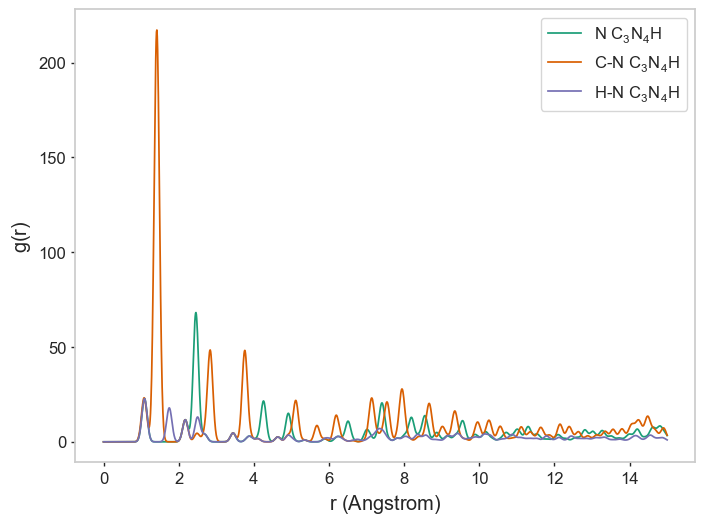

In [9]:
gnr1_doped_crystal.pdf.plot_projected_pdf(keys=[("N", ), ("C", "N"), ("H", "N")])

Calculated: 110592, Used: 1616, Ignored: 108976
Calculated distances in 0.003558635711669922 s


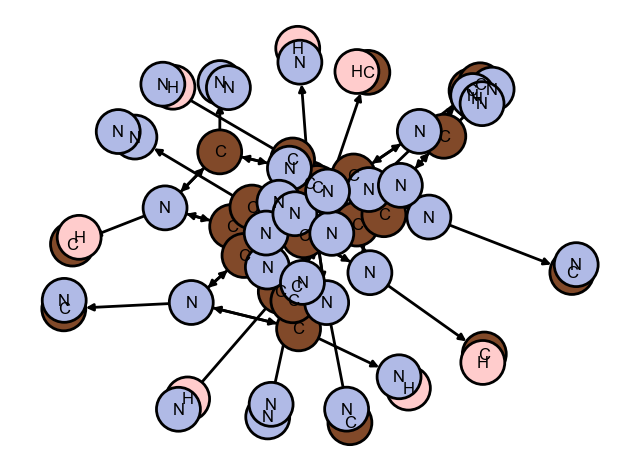

In [10]:
draw_network(gnr1_doped_crystal.network)